In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba

### Pyplot parameters for plotting
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',  # Use a serif font
    'font.size': 10,         # Adjust the font size to match your LaTeX document
})

# For a two-column document, set the figure width to be within the column width
column_width_pt = 246  # Adjust this based on your document's column width
inches_per_pt = 1/72.27
golden_ratio = (5**0.5 - 1) / 2  # Golden ratio to make the figure aesthetically pleasing

fig_width = column_width_pt * inches_per_pt
fig_height = fig_width * golden_ratio



plt.style.use('default')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "lines.linewidth" : 1.2,
          'xtick.minor.width' : 0.75,
          'xtick.major.width' : 0.75,
          'ytick.minor.width' : 0.75,
          'ytick.major.width' : 0.75,
          'axes.spines.top' : True,
          'axes.spines.right' : True,
          'axes.linewidth' : 1.5}
plt.rcParams.update(params)
plt.rc('figure', figsize=(fig_width, fig_height))
plt.rc('legend', frameon=False)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

def blocking_cv(x,temperatura, n = 1000):
    x = np.array(x)
    n0 = int(len(x)/n)
    cvs = np.zeros(n0)
    for idx in range(n0):
        e0 = x[idx*n:(idx+1)*n]
        e0sq = np.power(e0,2)
        cvs[idx] = (np.mean(e0sq)-np.mean(e0)**2)/(temperatura*temperatura)
    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def bootstrap_cv(x, temperatura, n=100):
    x = np.array(x)
    cvs = np.zeros(n)
    for iteration in range(n):
        x_resampled = np.random.choice(x,len(x))
        cvs[iteration] = (np.mean(np.power(x_resampled,2))-np.mean(x_resampled)**2)/(temperatura**2)

    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def process_data(fileRoot,numFiles,nSpins, distances, bootstrap_n = 1000):  
    e_mean = np.zeros(numFiles)
    m_mean = np.zeros(numFiles)
    cv_mean = np.zeros(numFiles)
    cv_mean_err = np.zeros(numFiles)
    corr_mean = np.zeros((distances+1,numFiles))
    amount = 0
    headers = ['Energia','Magnetizacion','Temperatura']
    temp_list = []
    for idx in range(distances+1):
        headers.append('Corr'+str(idx))
    for idx in range(numFiles):
        procesos_df = pd.read_csv(fileRoot+str(idx)+".csv",delimiter="\t", skiprows = 1, header = None,names = headers)
        e = np.array(procesos_df["Energia"].to_list())

        #print("Unit cells: ",int(nSpins/24),"Current file idx",idx,'       ',end ='\r')
        m = np.array(procesos_df["Magnetizacion"].to_list())
        t = np.array(procesos_df["Temperatura"].to_list())
        t = t[0]
        print("Mean mag gs: ",np.mean(m[e == np.min(e)])/(nSpins)," Lowest energy is: ",np.min(e),"At temperature: ", t)
        #print(t)
        #plt.plot(e[:100])
        e_mean[idx] = np.mean(e)
        cvs =  bootstrap_cv(e,t,n = bootstrap_n)
        cv_mean[idx] += cvs[0]
        cv_mean_err[idx] += cvs[1]
        m_mean[idx] = np.mean(m)
        temp_list.append(t)
        
    return (corr_mean/(amount),e_mean/(nSpins),m_mean/(nSpins),cv_mean/(nSpins),cv_mean_err/(nSpins),np.array(temp_list))

### No external field

In [3]:
#corr64,e64,m64,cv64,cverr64, t64 = process_data("../PT-Data/0Field/DatosN64Proceso",50,24*64,9)
#corr1, e1,m1,cv1,cverr1, t1 = process_data("../PT-Data/0Field/DatosN1Proceso",50,24,-1)
#corr8, e8,m8,cv8,cverr8, t8 = process_data("../PT-Data/0Field/DatosN8Proceso",50,24*8,-1)
corr512, e512,m512,cv512,cverr512, t512 = process_data("../PT-Data/0Field/DatosN512Proceso",50,24*512,-1)

KeyboardInterrupt: 

In [4]:
np.save("./ProcessedData/corr512.npy",corr512)
np.save("./ProcessedData/e512.npy",e512)
np.save("./ProcessedData/m512.npy",m512)
np.save("./ProcessedData/cv512.npy",cv512)
np.save("./ProcessedData/cverr512.npy",cverr512)
np.save("./ProcessedData/t512.npy",t512)

# np.save("./corr64.npy",corr64)
# np.save("./e64.npy",e64)
# np.save("./m64.npy",m64)
# np.save("./cv64.npy",cv64)
# np.save("./cverr64.npy",cverr64)
# np.save("./t64.npy",t64)

# np.save("./e1.npy",e1)
# np.save("./m1.npy",m1)
# np.save("./cv1.npy",cv1)
# np.save("./cverr1.npy",cverr1)
# np.save("./t1.npy",t1)

# np.save("./e8.npy",e8)
# np.save("./m8.npy",m8)
# np.save("./cv8.npy",cv8)
# np.save("./cverr8.npy",cverr8)
# np.save("./t8.npy",t8)


In [2]:
corr64 = np.load("./ProcessedData/corr64.npy")
e64 = np.load("./ProcessedData/e64.npy")
m64 = np.load("./ProcessedData/m64.npy")
cv64 = np.load("./ProcessedData/cv64.npy")
cverr64 = np.load("./ProcessedData/cverr64.npy")
t64 = np.load("./ProcessedData/t64.npy")

e1 = np.load("./ProcessedData/e1.npy")
m1 = np.load("./ProcessedData/m1.npy")
cv1 = np.load("./ProcessedData/cv1.npy")
cverr1 = np.load("./ProcessedData/cverr1.npy")
t1 = np.load("./ProcessedData/t1.npy")

e8 = np.load("./ProcessedData/e8.npy")
m8 = np.load("./ProcessedData/m8.npy")
cv8 = np.load("./ProcessedData/cv8.npy")
cverr8 = np.load("./ProcessedData/cverr8.npy")
t8 = np.load("./ProcessedData/t8.npy")

corr512 = np.load("./ProcessedData/corr512.npy")
e512 = np.load("./ProcessedData/e512.npy")
m512 = np.load("./ProcessedData/m512.npy")
cv512 = np.load("./ProcessedData/cv512.npy")
cverr512 = np.load("./ProcessedData/cverr512.npy")
t512 = np.load("./ProcessedData/t512.npy")

e48open = np.load("./ProcessedData/e48open.npy")
t48open = np.load("./ProcessedData/t48open.npy")
cv48open = np.load("./ProcessedData/cv48open.npy")
cverr48open = np.load("./ProcessedData/cverr48open.npy")

e363open = np.load("./ProcessedData/e363open.npy")
t363open = np.load("./ProcessedData/t363open.npy")
cv363open = np.load("./ProcessedData/cv363open.npy")
cverr363open = np.load("./ProcessedData/cverr363open.npy")

e960open = np.load("./ProcessedData/e960open.npy")
t960open = np.load("./ProcessedData/t960open.npy")
cv960open = np.load("./ProcessedData/cv960open.npy")
cverr960open = np.load("./ProcessedData/cverr960open.npy")

In [8]:
print(cverr960open)

[0.00000000e+00 7.24754313e-06 9.75487223e-05 1.92208046e-04
 2.43040829e-04 2.85183702e-04 3.09728377e-04 3.25598018e-04
 3.45425425e-04 3.43967396e-04 3.60389177e-04 3.77369970e-04
 3.65808602e-04 3.82543377e-04 4.02952639e-04 3.71666413e-04
 3.91814000e-04 3.84574098e-04 3.78158685e-04 3.64215794e-04
 3.61940965e-04 3.57503156e-04 3.53074919e-04 3.32006195e-04
 3.23188703e-04 3.21750538e-04 3.06486413e-04 2.77301870e-04
 2.81467532e-04 2.67823533e-04 2.57529753e-04 2.37739453e-04
 2.26902381e-04 2.20043245e-04 1.97159721e-04 1.85106224e-04
 1.63946252e-04 1.67089040e-04 1.47501784e-04 1.31549951e-04
 1.23526710e-04 1.06931655e-04 9.34676598e-05 7.93484478e-05
 7.26899438e-05 6.00125876e-05 4.92291179e-05 3.79757436e-05
 2.85349059e-05 2.40188942e-05]


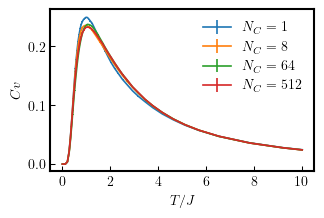

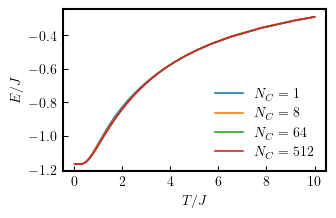

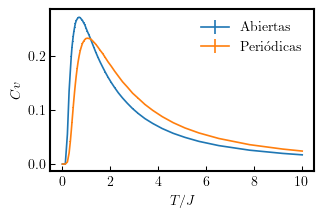

In [26]:
figCv, axCv = plt.subplots() 
axCv.errorbar(np.array(t1),cv1,2*cverr1, label = r'$N_C = 1$')
axCv.errorbar(np.array(t8),cv8,2*cverr8, label = r'$N_C = 8$')
axCv.errorbar(np.array(t64),cv64,2*cverr64, label = r'$N_C = 64$')
axCv.errorbar(np.array(t512),cv512,2*cverr512, label = r'$N_C = 512$')
axCv.set_ylabel(r'$Cv$')
axCv.set_xlabel(r'$T/J$')
axCv.legend()
figCv.savefig("./fig_chHypModels_Cv37.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
figCv.show()


figEnergy, axEnergy = plt.subplots()
axEnergy.plot(np.array(t1),e1, label = r'$N_C = 1$')
axEnergy.plot(np.array(t8),e8, label = r'$N_C = 8$')
axEnergy.plot(np.array(t64),e64, label = r'$N_C = 64$')
axEnergy.plot(np.array(t512),e512, label = r'$N_C = 512$')
axEnergy.set_ylabel(r'$E/J$')
axEnergy.set_xlabel(r'$T/J$')
axEnergy.legend()
figEnergy.savefig("./EnergyAntiferro.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
figEnergy.show()


figCvOp, axCvOp = plt.subplots() 
axCvOp.errorbar(np.array(t960open),cv960open,2*cverr960open, label = r'Abiertas')
axCvOp.errorbar(np.array(t512),cv512,2*cverr512, label = r'Periódicas')
axCvOp.set_ylabel(r'$Cv$')
axCvOp.set_xlabel(r'$T/J$')
axCvOp.legend()
figCvOp.savefig("test.png")
figCvOp.show()
figCvOp.savefig("./fig_chHypModels_Cv37OpvsPer.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
#figCvOp.show()


In [43]:
corr64[-1,:] =corr64[-1,:]/(64*24) 

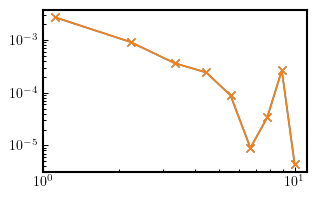

In [47]:
figCorr, axCorr = plt.subplots()
axCorr.plot(np.linspace(0,10,10)[1:],np.abs(corr64)[1:,0],'x-', label = r'$N_C = 1$')
axCorr.plot(np.linspace(0,10,10)[1:],np.abs(corr64)[1:,1],'x-', label = r'$N_C = 1$')
axCorr.set_xscale('log')
axCorr.set_yscale('log')

[0.22611943 0.11366123]


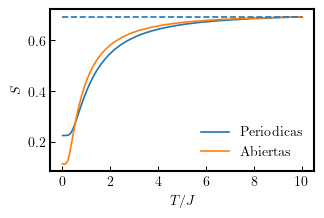

In [25]:
### Entropy calculation
from scipy.integrate import simps as simps
from scipy.integrate import trapz as trapz
def entropy(cv, temp):
    e1 = [np.log(2)-trapz(cv[n:]/temp[n:],temp[n:]) for n in range(len(cv))]
    return e1


figEntropy, axEntropy = plt.subplots()


#axEntropy.plot(t1,entropy(cv1,t1), label = r'$N_C = 1$')
#axEntropy.plot(t8,entropy(cv8,t8), label = r'$N_C = 8$')
#axEntropy.plot(t64,entropy(cv64,t64), label = r'$N_C = 64$')
axEntropy.plot(t512,entropy(cv512,t512), label = r'Periodicas')
axEntropy.plot(t960open,entropy(cv960open,t960open), label = r'Abiertas')
axEntropy.hlines(np.log(2),0,10,linestyles='dashed')
axEntropy.set_ylabel(r'$S$')
axEntropy.set_xlabel(r'$T/J$')
axEntropy.legend()

entropies = np.array([entropy(cv512,t512)[0],entropy(cv960open,t960open)[0]])

figEntropy.savefig("./fig_chHypModels_entropy37.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
figEntropy.show()
print(entropies)

## With external field

In [23]:
corr8F, e8F,m8F,cv8F,cverr8F, t8F = process_data("../PT-Data/05Field/DatosN8Proceso",50,24*8,-1,10)
corr8F1, e8F1,m8F1,cv8F1,cverr8F1, t8F1 = process_data("../PT-Data/150Field/DatosN8Proceso",50,24*8,-1,10)



Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.01
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.131376
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.219251
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.289728
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.340823
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.379602
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.408956
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.434811
Mean mag gs:  0.125  Lowest energy is:  -236 At temperature:  0.459629
Mean mag gs:  0.10416666666666667  Lowest energy is:  -234 At temperature:  0.486642
Mean mag gs:  0.10416666666666667  Lowest energy is:  -234 At temperature:  0.516451
Mean mag gs:  0.10416666666666667  Lowest energy is:  -234 At temperature:  0.549955
Mean mag gs:  0.10416666666666667  Lowest energy is:  -234 At temperature:  0.585714
Mean mag gs:  0.104166666

In [14]:
nfinal = 50
plt.plot(cvF[:nfinal],cvF[:nfinal])
plt.plot(cvF1[:nfinal],cvF1[:nfinal])

NameError: name 'cvF' is not defined

[0.16433916 0.10777446 0.11366247]


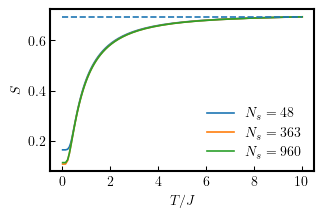

In [7]:
figEntropyOpen, axEntropyOpen = plt.subplots()

axEntropyOpen.plot(t48open,entropy(cv48open,t48open), label = r'$N_s = 48$')
axEntropyOpen.plot(t363open,entropy(cv363open,t363open), label = r'$N_s = 363$')
axEntropyOpen.plot(t960open,entropy(cv960open,t960open), label = r'$N_s = 960$')
axEntropyOpen.hlines(np.log(2),0,10,linestyles='dashed')
axEntropyOpen.set_ylabel(r'$S$')
axEntropyOpen.set_xlabel(r'$T/J$')
axEntropyOpen.legend()

entropiesOpen = np.array([entropy(cv48open,t48open)[0],entropy(cv363open,t363open)[0],entropy(cv960open,t960open)[0]])
print(entropiesOpen)
figEntropyOpen.savefig("./fig_chHypModels_entropy37Open.eps",format = 'eps',dpi=800, bbox_inches = 'tight',pad_inches = 0.03)
figEntropyOpen.show()

### Temperature ladder

In [5]:
### Workers analysis

def process_workers(fileRoot,numFiles):
    procesos_dfs = []
    for idx in range(numFiles):
        procesos_dfs.append(pd.read_csv(fileRoot+str(idx)+".csv",delimiter="\t"))
    dfs = pd.concat(procesos_dfs, join="inner")

    temp_list = sorted(list(dfs["Temperature"].value_counts().index))
    a_timeseries = []
    m_timeseries = []
    for t in temp_list:
        a_timeseries.append(np.array(dfs[dfs["Temperature"] == t]["Accepts"].to_list()))
        m_timeseries.append(np.array(dfs[dfs["Temperature"] == t]["Total"].to_list()))
    a_mean = np.sum(np.array(a_timeseries),axis = 1)
    m_mean = np.sum(np.array(m_timeseries),axis = 1)
    plt.plot(temp_list,a_mean/m_mean)
    plt.show()
    return procesos_dfs
    

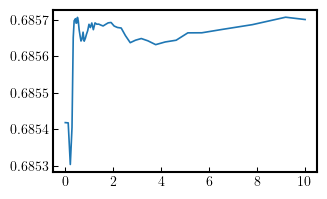

In [6]:
procesos_dfs = process_workers("../PT-Data/Open/CountersProceso1",50)

In [8]:
m = 50
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

t64 = np.array(t8F)
f_functions = []
upts = np.zeros(len(t64))
dwns = np.zeros(len(t64))
others = np.zeros(len(t64))
for n in range(m):
    print(n,'       ', end = '\r')
    ts = np.array(procesos_dfs[n].Temperature)
    labels = np.zeros(len(ts))
    currentLabel = 0
    for idx,t in enumerate(ts):
        if t == t64[0]:
            currentLabel = 1
        elif t==t64[-1]:
            currentLabel = -1
        labels[idx] = currentLabel    
        

    for idxt,t in enumerate(t64):
        upts[idxt] += np.sum((ts == t) & (labels == 1))
        dwns[idxt] += np.sum((ts == t) & (labels == -1))
        others[idxt] += np.sum((ts == t) & (labels == 0))


[1.00000000e+00 9.99099995e-01 7.29092739e-01 1.88151255e-01
 5.02753352e-02 2.33130505e-02 1.57261702e-02 1.24276522e-02
 1.08673997e-02 9.49150710e-03 8.60818493e-03 7.93262325e-03
 7.48801627e-03 7.21142538e-03 6.72089422e-03 6.38871790e-03
 6.02220921e-03 5.73360408e-03 5.62724857e-03 5.57723312e-03
 5.40106700e-03 5.25267162e-03 4.87211328e-03 4.77599455e-03
 4.57179337e-03 4.34957930e-03 4.21736594e-03 4.10520449e-03
 3.83110328e-03 3.64096248e-03 3.42271478e-03 3.26644704e-03
 3.07817894e-03 2.96405817e-03 2.89797662e-03 2.72189006e-03
 2.53986609e-03 2.23970551e-03 2.17158850e-03 2.06151332e-03
 1.85741049e-03 1.74139878e-03 1.47331676e-03 1.22923970e-03
 1.07316205e-03 8.89125367e-04 7.03090699e-04 4.49040863e-04
 2.89017630e-04 0.00000000e+00]
[0.01, 0.0324181472, 0.0548241568, 0.077242304, 0.0996604512, 0.12207859839999999, 0.1410774, 0.15765941249999998, 0.174241425, 0.1908234375, 0.20740545, 0.2232118074, 0.2370675856, 0.2509163161, 0.2647720943, 0.2786278725, 0.2918484424

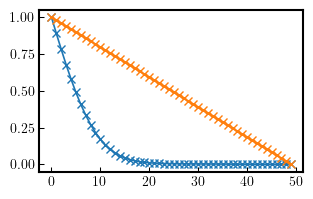

In [11]:
from scipy.stats import linregress as lr
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate



t64 = np.array(t363open)
fFunc = upts/(upts+dwns)
print(fFunc)
fSmooth = fFunc
deltaTs = np.diff(t64)

for idx in range(len(fFunc)-1):
    if fFunc[idx+1] > fFunc[idx]:
        fFunc[idx+1] = fFunc[idx]

for smoothing in range(200):
    for idx in range(1,len(fFunc)-1):
        fSmooth[idx] = 0.1*fFunc[idx-1]+0.8*fFunc[idx]+0.1*fFunc[idx+1]
    fFunc = fSmooth


num_interp = 10000

t_interp = []
f_interp = []

for idxI in range(1,len(fFunc)):
    for idxJ in range(num_interp):
        t_interp.append((1.0*idxJ)/num_interp*(t64[idxI]-t64[idxI-1])+t64[idxI-1])
        f_interp.append((1.0*idxJ)/num_interp*(fFunc[idxI]-fFunc[idxI-1])+fFunc[idxI-1])

t_interp = np.array(t_interp)
f_interp = np.array(f_interp)

f_Linear = np.linspace(f_interp.max(),f_interp.min(),len(fFunc))

newTs = np.zeros(len(fFunc))
newTs[0] = t64[0]
newTs[-1] = t64[-1]
for idxI in range(1,len(fFunc)-1):
    idx = np.argmin(np.abs(f_interp-f_Linear[idxI]))
    newTs[idxI] = t_interp[idx] 

print(list(newTs))
plt.plot(fFunc,'x-')
plt.plot(f_Linear,'x-')
#plt.plot(t_interp,f_interp-f_Linear[39],)
#plt.show()

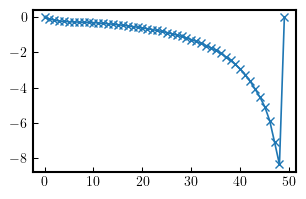

In [12]:
plt.plot(newTs-t64,'x-')
#plt.plot(t64,'x-')

### Plateaus

In [24]:
def read_plateaus(fileRoot, numFiles):
    energy = np.zeros(95)
    magn = np.zeros(95)
    fields = np.linspace(0,7.5,1000)
    minEnergy = np.zeros(1000)
    minMagn = np.zeros(1000)
    energies = []
    magnetizations = []
    pairs = []
    for idx in range(numFiles):
        df = pd.read_csv(fileRoot+str(idx)+".csv",delimiter = '\t')
        e = np.array(df["Energia"].to_list())
        m = np.array(df["Magnetizacion"].to_list())
        f = np.array(df["Campo"].to_list())
        couplingEnergies = e+m*f
        for n in range(len(e)):
            currentEner = couplingEnergies[n]-fields*m[n]
            if (couplingEnergies[n],m[n]) not in pairs:
                energies.append(currentEner)
                magnetizations.append(m[n])
                pairs.append((couplingEnergies[n],m[n]))
    print(pairs)
    for fieldIdx,field in enumerate(fields):
        currentEnergies = [energies[n][fieldIdx] for n in range(len(energies))]
        idx = np.argmin(currentEnergies)
        minEnergy[fieldIdx] = currentEnergies[idx] 
        minMagn[fieldIdx] = magnetizations[idx]
    return (minEnergy,minMagn,fields)
energy, magn, field = read_plateaus("../PT-Data/Plateaus/DatosN64Proceso",100)
#energy8, magn8, field8 = read_plateaus("../PT-Data/Plateaus/DatosN8Proceso",100)

[(-1792.0, -8), (-1792.0, 36), (-1792.0, 56), (-1792.0, 72), (-1792.0, 92), (-1792.0, 116), (-1792.0, 140), (-1792.0, 144), (-1792.0, 180), (-1792.0, 200), (-1792.0, 204), (-1792.0, 196), (-1792.0, 216), (-1736.0, 256), (-1744.0, 256), (-1733.9999999999998, 266), (-1738.0000000000002, 262), (-1737.9999999999998, 262), (-1720.0, 272), (-1688.0, 292), (-1666.0, 302), (-1582.0000000000002, 342), (-1588.0, 344), (-1511.9999999999998, 384), (-1504.0, 388), (-1452.0, 416), (-1410.0, 438), (-1364.0, 456), (-1324.0, 484), (-1300.0, 496), (-1299.9999999999998, 496), (-1290.0000000000002, 502), (-1288.0, 504), (-1210.0, 530), (-1144.0, 552), (-1095.9999999999998, 568), (-1096.0000000000002, 568), (-1076.0, 572), (-1064.0000000000002, 572), (-1036.0, 584), (-1014.0, 590), (-998.0, 594), (-982.0, 598), (-892.0, 620), (-866.0, 626), (-778.0000000000005, 646), (-840.0, 632), (-672.0, 672), (-794.0, 642), (-758.0000000000005, 650), (-672.0000000000005, 672), (-671.9999999999995, 672), (-629.999999999

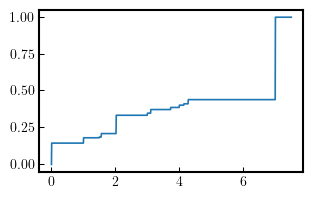

In [23]:
plt.plot(field,magn/(64*24))

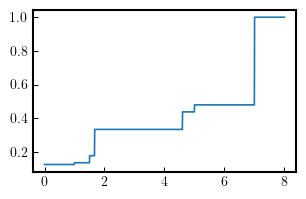

In [64]:
m1 = -200-hs*40
m2 = -222-hs*26
m3 = -160-hs*64
m4 = -212-hs*32
m6 = -210-hs*34
m7 = -224-hs*24
m8 = -224-hs*0
m9 = -68-hs*84
m10 = -28-hs*92
m11 = -14-hs*94
m12 = 672-hs*192



energy = np.zeros(len(hs))
mag = np.zeros(len(hs))
for n in range(len(hs)):
    test1 = np.argmin([m1[n],m2[n],m3[n],m4[n],m6[n],m7[n],m8[n],m9[n],m10[n],m11[n],m12[n]])
    test2 = np.min([m1[n],m2[n],m3[n],m4[n],m6[n],m7[n],m8[n],m9[n],m11[n],m11[n],m12[n]])
    mags = [40,26,64,32,34,24,0,84,92,94,192]
    mag[n] = np.min(mags[test1])
    energy[n] = test2

plt.plot(hs,mag/192)
